In [20]:

import itertools
import numpy as np
from astropy.io import fits
from tqdm import tqdm

def make_cigale_models(
    sfh='sfh2exp',
    metallicity=0.02,
    imf=1,
    stellar_library='cb19',
    #include_nebular=True,
    #include_dust=True,
    filename=None,
    **sfh_params
):
    """
    Generate one or multiple CIGALE models.
    Parameters in sfh_params can be scalars or lists.
    """

    keys, values = zip(*sfh_params.items()) if sfh_params else ([], [])
    grid = list(itertools.product(*[v if isinstance(v, (list, tuple, np.ndarray)) else [v] for v in values]))

    models = []
    for combo in tqdm(grid):
        params = dict(zip(keys, combo))

        # --- Inner block: your single-model builder ---
        sfh_module = _build_sfh_module(sfh, params)
        ssp_module = get_module(stellar_library, imf=imf, metallicity=metallicity)

        sed = SED()
        sfh_module.process(sed)
        ssp_module.process(sed)

        wl = sed.wavelength_grid * 10   # Å
        resolution = _compute_resolution(wl, stellar_library)

        # Flux conversion
        young_lum = sed.luminosities['stellar.young']
        old_lum = sed.luminosities['stellar.old']
        parsec = 3.0857e18
        young_flux = (young_lum / (4*np.pi * (10*parsec)**2)) * 100
        old_flux = (old_lum / (4*np.pi * (10*parsec)**2)) * 100

        # Spectrum object
        spec = Spectrum(wl=wl, resolution=resolution)
        spec.flux_young = young_flux
        spec.flux_old = old_flux
        spec.flux = young_flux + old_flux

        # Metadata
        spec.wl_units = 'A'
        spec.flux_units = 'erg/s/cm2/A'
        spec.header['SFH'] = sfh
        spec.header['STARLIB'] = stellar_library
        for key, value in params.items():
            spec.header[key] = value

        models.append(spec)

    # Save to FITS 
    if filename is not None:
        save_to_fits(filename,models)



    return models if len(models) > 1 else models[0]



def _build_sfh_module(sfh, params):
    if sfh == "sfh2exp":
        required = ["age", "tau_main"]
        missing = [p for p in required if p not in params]
        if missing:
            raise ValueError(f"sfh2exp requires {required}, missing {missing}")
        return get_module(
            'sfh2exp',
            age=params['age'],
            tau_main=params['tau_main'],
            tau_burst=params.get('tau_burst', 10),
            f_burst=params.get('f_burst', 0.0),
        )
    elif sfh == "sfhdelayed":
        required = ["age_main", "tau_main"]
        missing = [p for p in required if p not in params]
        if missing:
            raise ValueError(f"sfhdelayed requires {required}, missing {missing}")
        return get_module(
            'sfhdelayed',
            age_main=params["age_main"],
            tau_main=params["tau_main"],
            f_burst=params.get("f_burst", 0.0),
            age_burst=params.get("age_burst", 50),
            normalise=params.get("normalise", True),
        )
    elif sfh == "sfhperiodic":
        required = ["age", "period", "burst_age", "burst_fwhm"]
        missing = [p for p in required if p not in params]
        if missing:
            raise ValueError(f"sfhperiodic requires {required}, missing {missing}")
        return get_module(
            'sfhperiodic',
            age=params["age"],
            period=params["period"],
            burst_age=params["burst_age"],
            burst_fwhm=params["burst_fwhm"],
            normalise=params.get("normalise", True),
        )
    else:
        raise ValueError(f"Unsupported SFH '{sfh}'")

def _compute_resolution(wl, stellar_library):
    if stellar_library == 'bc03':
        delta_lambda = wl / 300
        delta_lambda[(wl >= 3200) & (wl <= 9500)] = 3.0
    elif stellar_library == 'cb19':
        delta_lambda = np.full_like(wl, 2.0)
        delta_lambda[(wl >= 912) & (wl <= 3540)] = 1.0
        delta_lambda[(wl >= 3540) & (wl <= 7350)] = 2.5
        delta_lambda[(wl >= 7350) & (wl <= 9400)] = 1.0
    else:
        print(f"WARNING: Unknown library {stellar_library}, using bc03 resolution.")
        delta_lambda = wl / 300
        delta_lambda[(wl >= 3200) & (wl <= 9500)] = 3.0
    return wl / delta_lambda

def save_to_fits(filename,models):
    
    # Primary HDU: wavelength array as data
    wl_data = models[0].wl.astype(np.float32)
    res_data = models[0].resolution.astype(np.float32)
    primary_hdu = fits.PrimaryHDU(data=[wl_data,res_data])
    primary_hdu.header["NMODEL"] = len(models)  # global metadata
    primary_hdu.header["WUNITS"] = 'angstroms'
    primary_hdu.header["FUNITS"] = 'erg/s/cm2/A'
    
    # Each model in its own extension
    model_hdus = []
    for i, spec in enumerate(models):
        cols = [
            fits.Column(name="FLUX",       array=spec.flux,       format="E"),
            fits.Column(name="FLUX_YOUNG", array=spec.flux_young, format="E"),
            fits.Column(name="FLUX_OLD",   array=spec.flux_old,   format="E"),
        ]
        hdu = fits.BinTableHDU.from_columns(cols, name=f"MODEL_{i}")

        # Save model-specific metadata
        for k, v in spec.header.items():
            try:
                hdu.header[k] = v
            except Exception:
                pass  # ignore keywords that FITS can't store

        model_hdus.append(hdu)

    hdul = fits.HDUList([primary_hdu] + model_hdus)
    hdul.writeto(filename, overwrite=True)


def load_spectrum_models_from_fits(filename):
    with fits.open(filename) as hdul:
        # Wavelength array from primary HDU
        wl,resolution = hdul[0].data
        nmodels = len(hdul) - 1

        models = []
        for i in range(1, len(hdul)):
            data = hdul[i].data
            header = hdul[i].header

            # Only the first model gets the wavelength array
            if i == 1:
                spec = Spectrum(wl=wl,resolution=resolution,flux=data["FLUX"])
            else:
                spec = Spectrum(wl=None, flux=data["FLUX"])  # copy wl if desired later

            spec.flux_young = data["FLUX_YOUNG"]
            spec.flux_old   = data["FLUX_OLD"]
            
            # Keep the model's metadata
            spec.header.update(header)

            models.append(spec)

    return models




In [21]:
import numpy as np
from dataclasses import dataclass, field

from astropy.io import fits
from astropy import units as u

from scipy.optimize import curve_fit
from scipy.stats import norm as stat_norm
from scipy.ndimage import gaussian_filter, median_filter
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.lines import Line2D

#from pangal.data.spectral_lines import spectral_lines, UBGVRI_filters, atmospheric_lines


@dataclass
class Spectrum:
    wl: np.ndarray=None                                       # wavelength
    resolution: np.ndarray=None                               # spectral resolution
    flux: np.ndarray=None                                     # flux
    flux_err:  np.ndarray=None                                # flux error
    wl_units: str=None                                        # x units: A, nm, eV, Hz, ...
    flux_units: str=None                                      # y units: erg/s/cm2/A, ....
    header: fits.Header = field(default_factory=fits.Header)  # FITS header (IF SPECTRUM IS DOWNLOADED FROM AN ARCHIVE, or if a model)
    id: str=None                                              # id

    
    @property
    def res_delta_lambda(self):
        """
        delta lambda (lambda): spectral resoolution
        """    
        return self.wl / self.resolution         
            

    def __call__(self, wavelength: float, kind: str = "linear") -> float:
        """
        Interpolate the flux at a given wavelength.
        
        Parameters
        ----------
        wavelength : float
            Wavelength (same units as self.wl)
        kind : str
            Interpolation kind ("linear", "nearest", etc.)
        
        Returns
        -------
        float
            Interpolated flux value.
        """
        if self.wl is None or self.flux is None:
            raise ValueError("Spectrum has no wavelength or flux defined.")
        
        return np.interp(wavelength, self.wl, self.flux)


    

    # Given a spectrum and a set of filters, it does the convolution with the transmission curve 
    # If I pass the bands it loads the transmission curve at each call
    # If I pass the transmission curves it does not have to load them each time, and it's fatster. Useful for fitting
    
    def get_phot(self, bands,
                 transmission_curves_funcs=None, transmission_lims=None, pivot_wl=None,
                 units='erg/s/cm2/A',):
        """
        Computes synthetic photometric points from a spectrum (in erg/s/cm2/A) and a list of bands.
        If transmission_curves_funcs, transmission_lims, and pivot_wl are passed, use them instead of reloading filters.
        """
        invalid = [b for b in bands if b not in map_filter_names]
        if invalid:
            raise ValueError(f"Unrecognized filters: {', '.join(invalid)}")
    
        spec_func = interp1d(self.wl, self.flux, bounds_error=False, fill_value=0.0)
        data = {}
    
        # Decide mode: internal (fast) or external (general)
        if transmission_curves_funcs and transmission_lims and pivot_wl:
            get_curve = lambda b: transmission_curves_funcs[b]
            get_lims = lambda b: transmission_lims[b]
            get_pivot = lambda b: pivot_wl[b]
        else:
            get_curve = lambda b: Filter(b).transmission_curve
            get_lims = lambda b: Filter(b).wavelength_range
            get_pivot = lambda b: Filter(b).pivot_wavelength  
    
        for b in bands:
            trans_curve = get_curve(b)
            lmin, lmax = get_lims(b)
    
            num_int, _ = quad(lambda l: trans_curve(l) * spec_func(l), lmin, lmax)
            norm_int, _ = quad(lambda l: trans_curve(l), lmin, lmax)
    
            phot_point = num_int / norm_int
            pivot_w = get_pivot(b)
    
            if units == 'mJy':
                phot_point = phot_point * pivot_w**2 / 3.99e18 / 1e-26
    
            # save as dict entry: band -> (value, error placeholder)
            data[b] = (phot_point, np.nan)
    
        header = fits.Header()
        header['units'] = units
    
        table = PhotometryTable(data=data, header=header)
    
        return table

    
    def plot(
        self,
        spectra=None,
        z=0.0,
        log=True,
        per_wavelength=False,
        winf=None,
        wsup=None,
        ymin=None,
        ymax=None,
        zoom_on_line=None,
        color='red',
        ecolor='green',
        show_snr=False,
        show_filters=False,
        show_spectral_lines=False,
        show_atmospheric_lines=False,
        figsize=None,
        bands=None,
        x_units=None,            # None = use native wavelength units
        y_units=None,            # None = use native flux units
        ):
        """
        Plot spectra with optional annotations and unit conversion.
    
        Parameters
        ----------
        x_units : str, optional
            Desired wavelength units for plotting. If None, uses the spectrum's native wl_units.
        y_units : str, optional
            Desired flux units for plotting. If None, uses the spectrum's native flux_units.
        """
    
        if spectra is None:
            spectra = [self]
        elif not isinstance(spectra, (list, tuple)):
            spectra = [spectra]
    
        if zoom_on_line is None:
            zoom_on_line = []
        if isinstance(zoom_on_line, str):
            zoom_on_line = [zoom_on_line]
    
        n_cols = max(1, len(zoom_on_line))
        figsize = figsize if figsize else (6 * n_cols, 4)
        fig, axes = plt.subplots(1, n_cols, figsize=figsize, squeeze=False)
    
        cols = zoom_on_line if zoom_on_line else [None]
    
        for j, line in enumerate(cols):
            ax = axes[0, j]
    
            for i, spec in enumerate(spectra):
    
                # Determine desired units for this specific spectrum
                x_u = x_units or spec.wl_units
                y_u = y_units or spec.flux_units
    
                # Make a working copy converted to desired units
                spec_conv = Spectrum(
                    wl=spec.wl.copy(),
                    flux=spec.flux.copy(),
                    flux_err=spec.flux_err.copy() if spec.flux_err is not None else None,
                    wl_units=spec.wl_units,
                    flux_units=spec.flux_units,
                    header=spec.header.copy(),
                    id=spec.id,
                ).convert_units(new_wl_units=x_u, new_flux_units=y_u)
    
                wl = spec_conv.wl
                flux = spec_conv.flux
                flux_err = spec_conv.flux_err
    
                # Apply λ × Fλ scaling if requested
                if per_wavelength:
                    flux = flux * wl
                    flux_err = flux_err * wl if flux_err is not None else None
    
                # Determine x-limits
                if line:
                    if line in spectral_lines:
                        center = spectral_lines[line] * (1 + z)
                    elif line in atmospheric_lines:
                        center = atmospheric_lines[line]
                    else:
                        raise ValueError(f"Line {line} not recognized")
                    x0, x1 = center - 70, center + 70
                else:
                    x0 = winf if winf is not None else wl[0]
                    x1 = wsup if wsup is not None else wl[-1]
    
                # Handle color
                if isinstance(color, (list, tuple)):
                    c = color[i % len(color)]
                elif color is None:
                    c = f"C{i}"
                else:
                    c = color
    
                # Plot the data
                if flux_err is not None:
                    ax.errorbar(
                        wl, flux, yerr=flux_err, fmt='o', markersize=2,
                        color=c, ecolor=ecolor, elinewidth=1.0,
                        capsize=2, capthick=1.0, linestyle='-', lw=0.5,
                        label=spec.id or f"Spectrum {i + 1}"
                    )
                else:
                    ax.plot(
                        wl, flux, color=c, lw=1,
                        label=spec.id or f"Spectrum {i + 1}"
                    )
    
                # Overlay synthetic photometric points
                if bands:
                    model_phot = self.get_phot(bands, units=y_u)
                    model_fluxes = np.array([model_phot.data[b][0] for b in bands], dtype=float)
                    wl_piv = np.array([Filter(b).pivot_wavelength for b in bands], dtype=float)
    
                    # Convert pivot wavelengths to plotting units
                    wl_piv = Spectrum._wl_to_angstrom(self, wl_piv, 'A', 2.99792458e18, 4.135667696e-15)
                    wl_piv = Spectrum._angstrom_to_wl(self, wl_piv, x_u, 2.99792458e18, 4.135667696e-15)
    
                    if per_wavelength:
                        model_fluxes = model_fluxes * wl_piv
    
                    ax.scatter(wl_piv, model_fluxes, c=color, marker='s', zorder=3)
    
                # Axis scaling
                if log:
                    ax.set_xscale('log')
                    ax.set_yscale('log')
    
                mask = (wl >= x0) & (wl <= x1)
                fmax = np.nanmax(flux[mask])
                fmin = np.nanmin(flux[mask])
    
                if ymin is None and ymax is None:
                    y1 = 1.2 * fmax
                    y0 = 1e-4 * fmax if fmin < 1e-4 * fmax else 0.8 * fmin
                else:
                    y0, y1 = ymin, ymax
    
                ax.set_xlim(x0, x1)
                ax.set_ylim(y0, y1)
    
            # --- Labels with actual units ---
            ax.set_xlabel(f"Wavelength ({x_u})")
            if not per_wavelength:
                ax.set_ylabel(f"Flux ({y_u})")
            else:
                ax.set_ylabel(f"$\\lambda F_\\lambda$ ({y_u})")
    
            ax.legend()
    
            # --- Optional overlays ---
            if show_filters:
                for name, props in UBGVRI_filters.items():
                    wmin = props["pivot_wavelength"] - props["bandwidth"] / 2
                    wmax = props["pivot_wavelength"] + props["bandwidth"] / 2
                    ax.axvspan(wmin, wmax, alpha=0.2, color=props["color"], label=f"{name} filter")
    
            if show_spectral_lines:
                for name, wavelength in spectral_lines.items():
                    wl_shift = wavelength * (1 + z)
                    ax.axvline(wl_shift, color="black", linestyle="dashed", alpha=0.7)
                    name_map = {'Ha':'$H\\alpha$', 'Hb':'$H\\beta$', 'Hg':'$H\\gamma$', 'Hd':'$H\\delta$', 'Lya':'Ly$\\alpha$'}
                    ax.text(wl_shift, 1.1 * fmax, name_map.get(name, name),
                            rotation=90, va="bottom", fontsize=10, ha='center', clip_on=True,
                            bbox=dict(facecolor='white', edgecolor='white', boxstyle='square,pad=0.2'))
    
            if show_atmospheric_lines:
                for name, wavelength in atmospheric_lines.items():
                    ax.axvline(wavelength, color="cyan", linestyle="dashed", alpha=0.7)
                    ax.text(wavelength, 1.1 * fmax, name, rotation=90, color='cyan',
                            va="bottom", fontsize=9, ha='center', clip_on=True,
                            bbox=dict(facecolor='white', edgecolor='white', boxstyle='square,pad=0.2'))
    
        plt.tight_layout()
        plt.show()


    # the units of wavelength and flux are stored in the header as wl_units and flux_units
    def convert_units(self, new_wl_units=None, new_flux_units=None):
        """
        Manual conversion of wavelength and flux units.
        Supported wl_units: A, nm, um, cm, m, Hz, eV
        Supported flux_units: erg/s/cm2/A, erg/s/cm2/nm, W/m2/um, Jy, mJy
        """
        c = 2.99792458e18  # Å/s
        h = 4.135667696e-15  # eV·s

        # ---- WAVELENGTH CONVERSIONS ----
        if new_wl_units and new_wl_units != self.wl_units:
            wl_A = self._wl_to_angstrom(self.wl, self.wl_units, c, h)
            self.wl = self._angstrom_to_wl(wl_A, new_wl_units, c, h)
            self.wl_units = new_wl_units
            self.header['WL_UNITS'] = new_wl_units

        # ---- FLUX CONVERSIONS ----
        if new_flux_units and new_flux_units != self.flux_units:
            self.flux = self._convert_flux(
                self.flux, self.wl, self.flux_units, new_flux_units, self.wl_units, c
            )
            self.flux_units = new_flux_units
            self.header['FLUX_UNITS'] = new_flux_units

        return self

    # ---------------- INTERNAL HELPERS ----------------
    def _wl_to_angstrom(self, wl, units, c, h):
        """Convert wavelength-like quantities to Å."""
        if units == 'A':
            return wl
        elif units == 'nm':
            return wl * 10
        elif units == 'um':
            return wl * 1e4
        elif units == 'cm':
            return wl * 1e8
        elif units == 'm':
            return wl * 1e10
        elif units == 'Hz':
            return c / wl
        elif units == 'eV':
            return (c * h) / wl
        else:
            raise ValueError(f"Unsupported wavelength unit: {units}")

    def _angstrom_to_wl(self, wl_A, units, c, h):
        """Convert Å to target wavelength-like unit."""
        if units == 'A':
            return wl_A
        elif units == 'nm':
            return wl_A / 10
        elif units == 'um':
            return wl_A / 1e4
        elif units == 'cm':
            return wl_A / 1e8
        elif units == 'm':
            return wl_A / 1e10
        elif units == 'Hz':
            return c / wl_A
        elif units == 'eV':
            return (c * h) / wl_A
        else:
            raise ValueError(f"Unsupported wavelength unit: {units}")

    def _convert_flux(self, flux, wl, old_units, new_units, wl_units, c):
        """Manual flux conversion with wavelength dependence."""
        # Convert wavelength to Å for consistency
        wl_A = self._wl_to_angstrom(wl, wl_units, c, 4.135667696e-15)
        wl_cm = wl_A * 1e-8

        # --- Convert old flux to erg/s/cm2/A ---
        if old_units == 'erg/s/cm2/A':
            f_lambda = flux
        elif old_units == 'erg/s/cm2/nm':
            f_lambda = flux / 10.0
        elif old_units == 'W/m2/um':
            f_lambda = flux * 1e7 / 1e4 / 1e4  # W→erg/s, m²→cm², μm→Å
        elif old_units == 'Jy':
            f_lambda = flux * 1e-23 * c / (wl_A**2)
        elif old_units == 'mJy':
            f_lambda = flux * 1e-26 * c / (wl_A**2)
        else:
            raise ValueError(f"Unsupported flux unit: {old_units}")

        # --- Convert erg/s/cm2/A to target ---
        if new_units == 'erg/s/cm2/A':
            return f_lambda
        elif new_units == 'erg/s/cm2/nm':
            return f_lambda * 10.0
        elif new_units == 'W/m2/um':
            return f_lambda / 1e7 * 1e4 * 1e4
        elif new_units == 'Jy':
            return f_lambda * (wl_A**2) / c / 1e-23
        elif new_units == 'mJy':
            return f_lambda * (wl_A**2) / c / 1e-26
        else:
            raise ValueError(f"Unsupported flux unit: {new_units}")













In [22]:


@dataclass
class PhotometryTable:
    data: dict = field(default_factory=dict)                      # Dictionary of {band: flux}
    region: object = None                                         # Region of sky (define externally or with shapely/sregions)
    header: fits.Header = field(default_factory=fits.Header)      # FITS header (for WCS/area info)

    @property
    def to_ABmag(self):
        if 'mJy' in self.header['units']:
            for band in self.data.keys(): 
                self.data[band] = self.mJy_to_ABmag(self.data[band])

    def mJy_to_ABmag(self, flux_mJy):
        flux_Jy = flux_mJy * 1e-3
        with np.errstate(divide='ignore'):
            mag = -2.5 * np.log10(flux_Jy) + 8.90
        return mag

    """
    def mJy_to_erg_s_cm2_A(self, flux_mJy, wavelength):
        flux_Jy = flux_mJy * 1e-3  # Jy
        fnu = flux_Jy * u.Jy
        wav = wavelength * u.AA
        flam = fnu.to(u.erg / u.s / u.cm**2 / u.AA, equivalencies=u.spectral_density(wav))
        return flam.value

    def MJy_sr_to_erg_s_cm2_A_arcsec2(self, flux_MJy_sr, wavelength):
        flux = flux_MJy_sr * u.MJy / u.sr
        wav = wavelength * u.AA
        flam = flux.to(u.erg / u.s / u.cm**2 / u.AA / u.arcsec**2, equivalencies=u.spectral_density(wav))
        return flam.value
    """

    @property
    def bands(self):
        print(self.data.keys())


    @property
    def pandas_df(self):
        df = pd.DataFrame.from_dict(self.data, orient='index', columns=['Value', 'Error'])
        df.index.name = 'Band'
        
        # Add SNR column
        df['SNR'] = df['Value'] / df['Error']
        
        #units = self.header.get('units', 'Unknown Units')
        return df

        


In [23]:
import numpy as np
import astropy
from bisect import bisect_left
from scipy.special import erf
from scipy.interpolate import RegularGridInterpolator, interp1d
import itertools
import os

from dynesty import NestedSampler
from dynesty import plotting as dyplot
from dynesty.utils import resample_equal
import corner

import sys, os
sys.path.append(os.path.expanduser('~/Desktop/Pangal'))

from pangal.image import Image
#from pangal.spectrum import Spectrum
from pangal.filters import Filter, map_filter_names, nice_filter_names, default_plot_scale_lims, default_plot_units, default_cmaps
from pangal.pfitter_utils import load_dust_emission_models, load_nebular_tables, model_grid_interpolator, dust_attenuation_curve
from scipy.integrate import quad

class PFitter(): # Parametric fitter

    def __init__(self, model_list, model_pars, cosmo=None, dustemimodel='dh02', leitatt=True, uv_bump=True, emimetal=0.0017, emimodel='2018'):


        self.model_pars = model_pars  # list the variables defyning the model grid

        # Menages model grid
        if not isinstance(model_list, list):
            raise ValueError("Error: model_grid is not a numpy array.")

        self.interp_young_flux, self.interp_old_flux, self.model_pars_arr, self.short_model_wl  = self.model_grid_interpolator(model_list, self.model_pars)

        #get the wavelength information for the dust templates to stitch it to the stellar model wl 
        #this_dir = os.path.dirname(os.path.abspath(__file__))
        #file_path = os.path.join(this_dir, 'data', f'spectra_{dustemimodel}.dat')
        
        file_path = '/home/utente/Desktop/Pangal/pangal/data/'+f'spectra_{dustemimodel}.dat'
        dust_wl = np.loadtxt(file_path, usecols=(0,)) * 1e4   # Load wavelength grid (in Angstroms)

        #print(dust_wl[0],dust_wl[-1])        

        #expand wavelength grid to include range covered by dust templates
        # Find the extended part of dust_wl
        extra_wl_mask = dust_wl > self.short_model_wl.max()
        extra_wl = dust_wl[extra_wl_mask]

        # Extend wavelength grid
        self.model_wl = np.r_[self.short_model_wl, extra_wl]

        # Extend resolution array with constant value matching the number of extra wavelengths
        last_res = model_list[0].resolution[-1]
        extra_res = np.full(extra_wl.size, last_res)

        # Concatenate the original model resolution with the extended constant resolution
        self.model_res = np.r_[model_list[0].resolution, extra_res]

        # PRECOMPUTES DUST ATTENUATION CURVE (Calzetti, 2000 + optional Leitherer+2002 + optional UV bump)
        self.k_cal = dust_attenuation_curve(self.model_wl, leitatt, uv_bump)

        # LOADS NEBULAR LINE TABLES
        self.nebular_func, self.nebular_ions, self.nebular_ages = self.load_nebular_tables(self.model_wl,self.model_res, emimetal,emimodel)

        # LOADS DUST EMISSION SPECTRA
        # This can be moved above for computing dust_wl only once?
        self.dustem_func, self.dustem_alpha = self.load_dust_emission_models(self.model_wl,dustemimodel)

    # methods
    load_nebular_tables = load_nebular_tables
    load_dust_emission_models = load_dust_emission_models
    dust_attenuation_curve = dust_attenuation_curve
    model_grid_interpolator = model_grid_interpolator


    def run_fit(self,
            
        spec= None,
        phot= None,

        bands= None,            # if I want to use only some of the bands in phot dict

        fix_pars={},          # dictionary 

        polymax = 7,    

        nlive = 500,

        ):
        """
        Fits photometry and/or spectra using a parametric model and returns Fit object(s).

        Supports:
        - spectrum only
        - photometric_dict only
        - both
        - lists of both (must have the same length)

        Returns:
        - a single Fit instance or a list of Fit instances
        """

        self.nlive = nlive
        self.fix_pars = fix_pars

        if bands: 
            for b in bands:
                if b not in map_filter_names.keys():
                    raise ValueError(f'Unrecognized filter: {b}. Abort')


        # Handle list vs. single inputs
        if isinstance(spec, list) or isinstance(phot, list):
            spec_list = spec if isinstance(spec, list) else [None] * len(phot)
            phot_list = phot if isinstance(phot, list) else [None] * len(spec)

            if len(spec_list) != len(phot_list):
                raise ValueError("Spectrum and photometric_dict lists must have the same length.")

            fits = [self.run_single_fit(s, p, bands) for s, p in zip(spec_list, phot_list)]

            # menages writing on file
            return fits
        else:
            
            fit = self.run_single_fit(spec, phot, bands)

            # menages writing on file
            return fit


    # This function is internal. Can't be called from outside
    def run_single_fit(self, spec, phot, bands):

        if phot and hasattr(phot, 'header') and 'redshift' in phot.header:
            self.redshift = phot.header['redshift']
        elif spec and hasattr(spec, 'header') and 'redshift' in spec.header:
            self.redshift = spec.header['redshift']
        else:
            print("Redshift not provided and not found in phot dictionary or spectrum header.")
            print("Redshift set to 0.")
            self.redshift = 0
       
        #Derive luminosity distance in Mpc
        if phot and 'dl' in phot.header.keys():
            self.dl = phot.header['dl']
        elif spec and hasattr(spec, 'header') and 'dl' in spec.header:
            self.dl = spec.header['dl']
        else:
            from astropy.cosmology import FlatLambdaCDM
            cosmo = FlatLambdaCDM(H0=70,Om0=0.3)        
            self.dl = cosmo.luminosity_distance(self.redshift).value

        if spec:
            self.spec = spec
            print('Fitting spectrum')

        if phot: 

            self.phot = phot

            # PRECOMPUTES FILTERS

            # Filter bands to only those present in map_filter_names
            if bands: 
                self.bands = bands
            else:
                self.bands = [b for b in phot.photometry.keys() if b in map_filter_names.keys()]

            filters = {b:Filter(b) for b in self.bands}
            self.transmission_curves_funcs = {b:filters[b].transmission_curve for b in self.bands}
            self.transmission_lims = {b:filters[b].wavelength_range for b in self.bands}
            self.pivot_wl = {b:filters[b].pivot_wavelength for b in self.bands} 

            # Print which filters are used
            print(f"Using the following photometric filters: {', '.join(self.bands)}")


            # Handles PARAMETERS: removes 
            free_pars = [p for p in self.model_pars + ["fesc", "ion_gas", "age_gas", "av", "av_ext", "alpha", "m_star"]
             if p not in self.fix_pars]
            self.free_pars = free_pars

        # Create the sampler
        log_likelihood = self.make_log_likelihood()
        #prior_transform = self.make_prior_tranform()
        prior_transform, priors_info = self.make_prior_transform()

        # Print the priors
        print("🔎 Priors for this model:")
        for par, prior in priors_info.items():
            print(f" - {par}: {prior}")
        
        if self.fix_pars:
            print("⚓ Fixed parameters:", ", ".join(self.fix_pars))

        print("Number of free parameters:", len(free_pars))

                

            
        print("Initializing live points")
            
        sampler = NestedSampler(log_likelihood, prior_transform, ndim=len(free_pars),nlive=100) #self.nlive

        # Run the nested sampling
        print("Running dynesty")
        sampler.run_nested(dlogz=0.01, print_progress=True)

        # Access results
        res = sampler.results

        return res

    

    def make_log_likelihood(self):
        def log_likelihood(pars):

            spec_lhood = 0
            phot_lhood = 0

            if self.phot:

                phot_points = np.array([self.phot.data[b][0] for b in self.bands])
                phot_errors = np.array([self.phot.data[b][1] for b in self.bands])

                upper_lims = (phot_points / phot_errors < 5).astype(int)

                # Unpacks parameters
                idx = 0
                n_model_pars = len(self.model_pars)
                model_pars = pars[idx : idx + n_model_pars]
                idx += n_model_pars

                param_names = ["fesc", "ion_gas", "age_gas", "av", "av_ext", "alpha", "m_star"]

                # Store in a local dict, then unpack manually
                param_values = {}
                for name in param_names:
                    if name in self.fix_pars:
                        param_values[name] = self.fix_pars[name]
                    else:
                        param_values[name] = pars[idx]
                        idx += 1

                # Now unpack them to true local variables (1 line)
                fesc, ion_gas, age_gas, av, av_ext, alpha, m_star = [param_values[n] for n in param_names]
                # parameters of the model grid
                kwargs = {key: value for key, value in zip(self.model_pars, model_pars)}
                
                # build total spectrum
                synth_spec = self.synthetic_spectrum(**kwargs, fesc=fesc, ion_gas=ion_gas, age_gas=age_gas, av=av, av_ext=av_ext, alpha=alpha, m_star=m_star, redshift=0,dl=100)#self.redshift, dl=self.dl)
                
                #print(synth_spec.flux)
                # get the synthetic photometric points out of the synthetic spectrum
                model_phot_table = synth_spec.get_phot(self.bands,
                                                       self.transmission_curves_funcs,self.transmission_lims,self.pivot_wl,
                                                       units='mJy')
                model_phot = [model_phot_table.data[b][0] for b in self.bands]


                #print(model_phot)
                

                
                for i in range(len(phot_points)):

                    if upper_lims[i] == 0:

                        phot_lhood += -0.5 * ( (phot_points[i]-model_phot[i])**2 / phot_errors[i]**2 + np.log(phot_errors[i]**2) + np.log(2.*np.pi) ) 

                    else: # upper limit: error function (integrated Gaussian probability)

                        terf = 0.5* ( 1 + erf( (phot_points[i]-model_phot[i])/np.sqrt(2.)/phot_errors[i]) ) # P(flux<upper limit)
                        phot_lhood += np.log(terf)
            

            #print(pars, spec_lhood + phot_lhood )

            if not np.isfinite(phot_lhood):
                return -1e100  # NOT -np.inf

            return spec_lhood + phot_lhood 

    
        return log_likelihood
        

    def make_prior_transform(self):
        priors_info = {}
    
        def prior_transform(u):
            x = np.zeros_like(u)
            n_model_pars = len(self.model_pars)
    
            for i in range(n_model_pars):
                low = 10
                high = 200
                x[i] = low + u[i] * (high - low)
                priors_info[f"model_par_{i}"] = f"Uniform({low}, {high})"
    
            idx = n_model_pars
    
            if 'fesc' not in self.fix_pars:
                x[idx] = u[idx]
                priors_info['fesc'] = "Uniform(0, 1)"
                idx += 1
    
            if 'ion_gas' not in self.fix_pars:
                x[idx] = u[idx] * (self.nebular_ions[-1] - self.nebular_ions[0]) + self.nebular_ions[0]
                priors_info['ion_gas'] = f"Uniform({self.nebular_ions[0]}, {self.nebular_ions[-1]})"
                idx += 1
    
            if 'age_gas' not in self.fix_pars:
                x[idx] = self.emm_ages[0] + u[idx] * (self.emm_ages[-1] + 1 - self.emm_ages[0])
                priors_info['age_gas'] = f"Uniform({self.emm_ages[0]}, {self.emm_ages[-1]+1})"
                idx += 1
    
            if 'av' not in self.fix_pars:
                x[idx] = u[idx] * 1.0
                priors_info['av'] = "Uniform(0, 1)"
                idx += 1
    
            if 'av_ext' not in self.fix_pars:
                x[idx] = u[idx] * 1.0
                priors_info['av_ext'] = "Uniform(0, 1)"
                idx += 1
    
            if 'alpha' not in self.fix_pars:
                x[idx] = u[idx] * (self.dustem_alpha[-1] - self.dustem_alpha[0]) + self.dustem_alpha[0]
                priors_info['alpha'] = f"Uniform({self.dustem_alpha[0]}, {self.dustem_alpha[-1]})"
                idx += 1
    
            if 'm_star' not in self.fix_pars:
                x[idx] = u[idx] * (11 - 7) + 7
                priors_info['m_star'] = "Uniform(7, 11)"
                idx += 1
    
            return x
    
        # Return both: the transform function and the priors dictionary
        return prior_transform, priors_info


    def synthetic_spectrum(self, fesc, ion_gas, age_gas, av, av_ext, alpha, m_star, redshift, dl, multi_component=False, **kwargs,):
        """
        Generate a physically motivated synthetic galaxy spectrum, combining stellar populations, nebular lines, 
        dust attenuation, and re-emission, redshifted and scaled for observational comparison.

        Parameters
        ----------
        fesc : float
            Escape fraction of ionizing photons (0 = fully absorbed by gas; 1 = no nebular emission).
        
        ion_gas : float
            Ionization parameter of the nebular gas.

        age_gas : float
            Age of the nebular region in Myr (affects emission line spectrum).

        av : float
            V-band attenuation for the old stellar population (in magnitudes).

        av_ext : float
            Extra V-band attenuation applied only to the young stellar population.

        alpha : float
            Parameter controlling the shape of the dust emission SED (Dale & Helou 2002 models).

        m_star : float
            Logarithmic stellar mass of the galaxy (in solar masses, log₁₀[M*/M☉]).

        redshift : float
            Redshift of the galaxy.

        dl : float
            Luminosity distance to the galaxy in parsecs (used for flux scaling).

        multi_component : bool, optional
            If True, returns sub-components (e.g., dust, young/old spectra) in the output Spectrum object for inspection or plotting.

        **kwargs :
            Passed to stellar population model interpolators (e.g., age, metallicity, SFH parameters).

        Returns
        -------
        Spectrum
            A synthetic `Spectrum` object with:
                - wavelength grid in observed frame (Angstrom),
                - flux in erg/s/cm²/Å,
                - optional components if `multi_component=True` (e.g., dust emission, attenuated spectra).

        Notes
        -----
        The returned spectrum is built in the following order:
        1. Interpolate young and old stellar templates on model grid.
        2. Compute ionizing photon rates to scale nebular emission.
        3. Add nebular emission lines based on gas parameters and fesc.
        4. Apply dust attenuation using a Calzetti-like law.
        5. Compute energy absorbed by dust and add thermal IR emission from templates.
        6. Apply redshifting and flux scaling for observer's frame.

        The resulting spectrum is suitable for SED fitting, photometry synthesis, or mock observation generation.
        """
        
        young_stellar_spec = self.interp_young_flux(**kwargs)
        old_stellar_spec = self.interp_old_flux(**kwargs)

        # Resample the flux from short_wl to model_wl
        young_stellar_spec = np.interp(self.model_wl, self.short_model_wl, young_stellar_spec)
        old_stellar_spec = np.interp(self.model_wl, self.short_model_wl, old_stellar_spec)


        # Number of lyman continuum photons
        # Spectra are corrected for lyman continuum absorption including escape fraction

        #get number of lyman continuum photons from the young stellar population and the old stellar population
        #spec in erg/s/cm2/A so it returns the flux of ionizing photons not the rate 
        index_lyman = np.searchsorted(self.model_wl, 912, side='left') #wavelength just above Lyman limit

        lycont_wls = np.r_[self.model_wl[:index_lyman], np.array([912])]

        lycont_spec = np.interp(lycont_wls, self.model_wl, young_stellar_spec) 
        
        nlyman_young = np.trapz(lycont_spec*lycont_wls, lycont_wls)/6.626e-27/2.998e18 * (1-fesc)

        lycont_spec = np.interp(lycont_wls, self.model_wl, old_stellar_spec)                        # WHY THIS? WHAT CHANGES?
        nlyman_old = np.trapz(lycont_spec*lycont_wls, lycont_wls)/6.626e-27/2.998e18 * (1-fesc)

        #modify input spec to remove photons 
        if fesc>=0:
            young_stellar_spec[:index_lyman] *= fesc
            old_stellar_spec[:index_lyman] *= fesc             # is this necessary ?? 

        nebular_lines = self.nebular_func(ion_gas,age_gas) 

        # to get the full spec normalized line spectra must be multiplied by the un-escaped number of lyman photons from the stellar model
        nebular_young = nebular_lines * nlyman_young 
        nebular_old = nebular_lines * nlyman_old

        young_stellar_nebular_spec = young_stellar_spec + nebular_young
        old_stellar_nebular_spec = old_stellar_spec + nebular_old
        stellar_nebular_spec = young_stellar_nebular_spec + old_stellar_nebular_spec


        # Dust attenuation

        #attenuate photometry spec, k_cal is precomputed in the rest frame as it should be
        att_young_stellar_nebular_spec = (10**(-(av+av_ext)*self.k_cal) * (young_stellar_nebular_spec))
        att_old_stellar_nebular_spec   = (10**(-av*self.k_cal) * (old_stellar_nebular_spec))
        att_stellar_nebular_spec  = att_young_stellar_nebular_spec + att_old_stellar_nebular_spec


        #### THERMAL DUST EMISSION ####
        lbol_init = np.trapz(stellar_nebular_spec, self.model_wl)
        lbol_att  = np.trapz(att_stellar_nebular_spec, self.model_wl)

        dust_bol = (lbol_init - lbol_att)
        
        # raw interpolated dust emission template. independent of your specific galaxy model. 
        # generic spec for a given α (which controls dust heating intensity).

        tdust_spec = self.dustem_func(alpha)

        # remove stellar component which is included in dale models
        # otherwise it is double-counted.
        mask_pixels = (self.model_wl >= 2.5e4) & (self.model_wl <= 3e4)
        scale = np.sum(stellar_nebular_spec[mask_pixels]*tdust_spec[mask_pixels]) / np.sum(stellar_nebular_spec[mask_pixels]*stellar_nebular_spec[mask_pixels])
        tdust_spec -= scale*stellar_nebular_spec
        tdust_spec[(self.model_wl < 2.5e4) | (tdust_spec < 0.)] = 0.

        # scale to the correct total energy to re-emit
        norm = np.trapz(tdust_spec, self.model_wl)     
        dust_spec = tdust_spec * dust_bol / norm

        total_spec = att_stellar_nebular_spec + dust_spec

        # move to the observed frame
        model_red_wl = self.model_wl * (1+redshift)
        total_spec /= (1+redshift)

        # this models are scaled to 1 solar mass at 10 pc
        # Rescale
        fscale = 10**m_star / (dl * 1e5)**2

        total_spec *= fscale 

        spec = Spectrum(wl=model_red_wl,resolution=self.model_res,flux=total_spec)

        if multi_component:
            # arrays usefull for plotting
            for s in [young_stellar_nebular_spec, old_stellar_nebular_spec, att_young_stellar_nebular_spec, att_old_stellar_nebular_spec, dust_spec]:
                s /= (1+redshift)
                s *= fscale 
            spec.young_stellar_nebular = young_stellar_nebular_spec
            spec.old_stellar_nebular = old_stellar_nebular_spec
            spec.att_young_stellar_nebular = att_young_stellar_nebular_spec
            spec.att_old_stellar_nebular = att_old_stellar_nebular_spec
            spec.dust = dust_spec

        return spec
        

    def cornerplot(self,fit_result):

        # Get weighted samples
        samples, weights = fit_result.samples, np.exp(fit_result.logwt - fit_result.logz[-1])
        
        # Resample to equal weights
        from dynesty.utils import resample_equal
        equal_samples = resample_equal(samples, weights)
        
        # Corner plot
        fig = corner.corner(equal_samples, labels=self.free_pars)
        plt.show()





In [7]:
from pangal.photometry_table import PhotometryTable, fits_to_PhotometryTable, print_photometric_tables

In [8]:
phot_table = fits_to_PhotometryTable('photometry_tables_NGC4848.fits')

In [9]:
print_photometric_tables(phot_table)

,Region 1,Region 2,Region 3,Region 4
Band,,,,
GALEX NUV,0.036 ± 0.002 (21.2),0.027 ± 0.001 (20.8),0.015 ± 0.001 (17.7),0.010 ± 0.001 (13.9)
GALEX FUV,0.021 ± 0.001 (20.7),0.012 ± 0.001 (18.6),0.005 ± 0.000 (11.2),0.003 ± 0.001 (5.9)
SDSS u,0.107 ± 0.007 (15.2),0.068 ± 0.011 (6.1),0.046 ± 0.017 (2.7),0.012 ± 0.023 (0.5)
SDSS g,0.362 ± 0.005 (73.5),0.263 ± 0.006 (41.5),0.167 ± 0.012 (14.4),0.119 ± 0.013 (9.4)
SDSS r,0.542 ± 0.007 (73.5),0.440 ± 0.010 (43.1),0.289 ± 0.018 (16.0),0.202 ± 0.020 (10.3)
SDSS i,0.671 ± 0.010 (65.8),0.578 ± 0.019 (31.0),0.405 ± 0.024 (17.0),0.275 ± 0.033 (8.4)
SDSS z,0.803 ± 0.030 (26.5),0.697 ± 0.038 (18.4),0.528 ± 0.059 (8.9),0.380 ± 0.094 (4.1)
HST WFC3 UVIS F350LP,0.511 ± 0.007 (70.2),0.387 ± 0.010 (40.7),0.251 ± 0.015 (16.9),0.175 ± 0.019 (9.0)
HST WFC3 UVIS F600LP,0.735 ± 0.010 (70.2),0.590 ± 0.012 (50.1),0.386 ± 0.020 (19.7),0.263 ± 0.027 (9.6)


In [26]:
from pcigale.sed import SED
from pcigale.sed import utils
from pcigale.sed_modules import get_module

In [27]:
specs = make_cigale_models(sfh='sfh2exp',
                   metallicity=0.02,
                   imf=1,
                   stellar_library='cb19',
                   include_nebular=False,
                   include_dust=True,
                   age=[100,300,500,700,1000], tau_main=[100,200,400],
                   filename = 'test_models',
                  )

100%|███████████████████████████████████████████| 15/15 [00:10<00:00,  1.46it/s]


In [28]:
specs = load_spectrum_models_from_fits('test_models')

In [34]:
print(specs[0].flux_units)

None


In [29]:
specs[0].flux_young

array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.2824240e-22,
       9.9832083e-23, 6.9905584e-23], dtype='>f4')

In [30]:
specs[0].get_phot(bands=['sdss_u','sdss_r'])

/tmp/ipykernel_53243/1936199390.py:97: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  norm_int, _ = quad(lambda l: trans_curve(l), lmin, lmax)


PhotometryTable(data={'sdss_u': (1.1305987844441305e-13, nan), 'sdss_r': (4.4041264619114693e-14, nan)}, region=None, header=UNITS   = 'erg/s/cm2/A'                                                         )

/tmp/ipykernel_53243/1936199390.py:97: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  norm_int, _ = quad(lambda l: trans_curve(l), lmin, lmax)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 specs[0].plot(per_wavelength=True,bands=['galex_nuv','sdss_u','sdss_g','sdss_r','sdss_i'     │
│   2 │   │   │   │   │   │   │   │   │   │   │   │   │    'spitzer_irac_1','spitzer_irac_2','     │
│   3                                                                                              │
│                                                                                                  │
│ in plot:237                                                                                      │
│                                                                                                  │
│   234 │   │   │   │   │                                                                          │
│   235 │   │   │   │   │   # Convert pivot wavelengths to plotting units                          │
│   236 │   │   │   │   │   wl_piv = Spectrum._wl_to_angstrom(self, wl_piv, 'A', 2.99792458e18,    │
│ ❱ 237 │   │   │   │   │   wl_piv = Spectrum._angstrom_to_wl(self, wl_piv, x_u, 2.99792458e18,    │
│   238 │   │   │   │   │                                                                          │
│   239 │   │   │   │   │   if per_wavelength:                                                     │
│   240 │   │   │   │   │   │   model_fluxes = model_fluxes * wl_piv                               │
│                                                                                                  │
│ in _angstrom_to_wl:362                                                                           │
│                                                                                                  │
│   359 │   │   elif units == 'eV':                                                                │
│   360 │   │   │   return (c * h) / wl_A                                                          │
│   361 │   │   else:                                                                              │
│ ❱ 362 │   │   │   raise ValueError(f"Unsupported wavelength unit: {units}")                      │
│   363 │                                                                                          │
│   364 │   def _convert_flux(self, flux, wl, old_units, new_units, wl_units, c):                  │
│   365 │   │   """Manual flux conversion with wavelength dependence."""                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: Unsupported wavelength unit: None

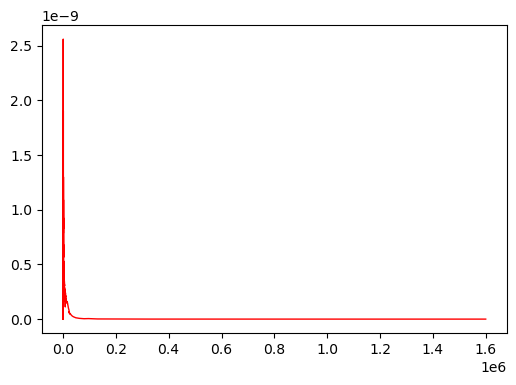

In [31]:
specs[0].plot(per_wavelength=True,bands=['galex_nuv','sdss_u','sdss_g','sdss_r','sdss_i','sdss_z',
                                                     'spitzer_irac_1','spitzer_irac_2','spitzer_irac_3','spitzer_irac_4'])

In [348]:
#for s in spec:
#    s.plot(show_spectral_lines=False,log=True,per_wavelength=True,bands=['sdss_u','sdss_r'],)

In [132]:
#spec[0].plot(show_spectral_lines=False,zoom_on_line=['Ha','Hb'],spectra=[spec[0],spec[2],spec[-1]],log=True,ymin=3e-15,ymax=8e-14)  

In [133]:
#spec[0].plot(show_spectral_lines=False,spectra=[spec[0],spec[2],spec[-1]],log=True,per_wavelength=True) 

In [134]:
#spec[2].plot(show_spectral_lines=True,spectra=[spec_models[0],spec_models[10],spec_models[-1]],log=True)

In [14]:
fitter = PFitter(specs,
                 model_pars=['age','tau_main'],
                )

Loading nebular lines templates from  nebular_Byler_mist_2018.lines
 Emission line metallicity requested 0.0017, found 0.0020
Tabulated values for ionized gas age (Myr): [ 0.5  1.   2.   3.   4.   5.   6.   7.  10. ]
Tabulated values for ionization coefficient: [-4.  -3.5 -3.  -2.5 -2.  -1.5 -1. ]
Loading of nebular lines templates completed.
Tabulated alpha values from 'alpha_dh02.dat': [0.0625 0.125  0.1875 0.25   0.3125 0.375  0.4375 0.5    0.5625 0.625
 0.6875 0.75   0.8125 0.875  0.9375 1.     1.0625 1.125  1.1875 1.25
 1.3125 1.375  1.4375 1.5    1.5625 1.625  1.6875 1.75   1.8125 1.875
 1.9375 2.     2.0625 2.125  2.1875 2.25   2.3125 2.375  2.4375 2.5
 2.5625 2.625  2.6875 2.75   2.8125 2.875  2.9375 3.     3.0625 3.125
 3.1875 3.25   3.3125 3.375  3.4375 3.5    3.5625 3.625  3.6875 3.75
 3.8125 3.875  3.9375 4.    ]
Loading of dust emission templates completed.


/tmp/ipykernel_92879/2254392165.py:95: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  norm_int, _ = quad(lambda l: trans_curve(l), lmin, lmax)


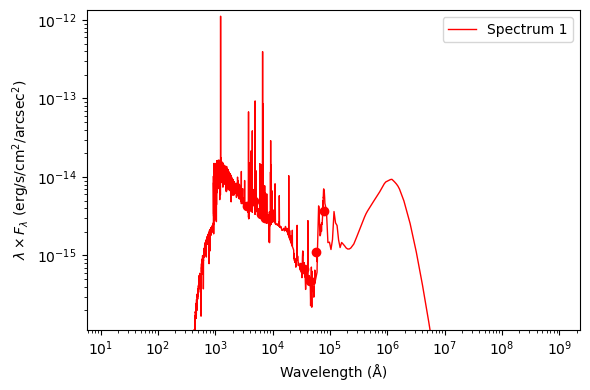

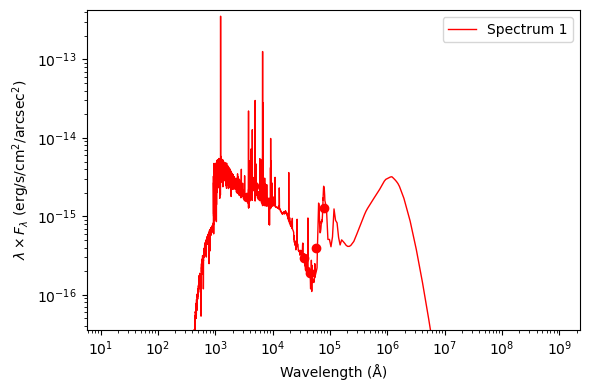

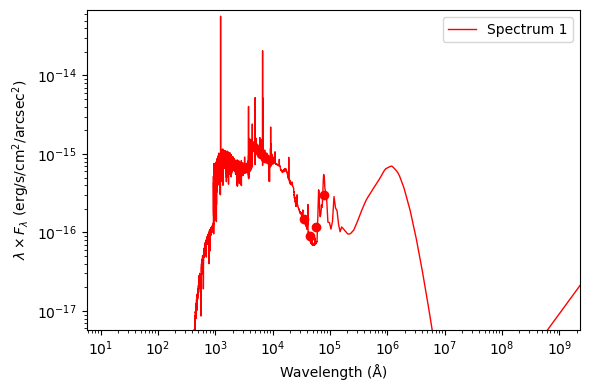

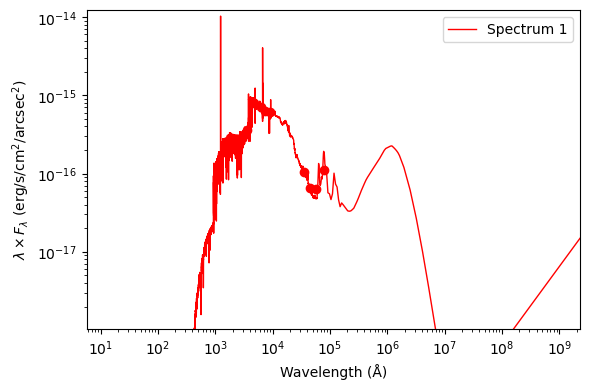

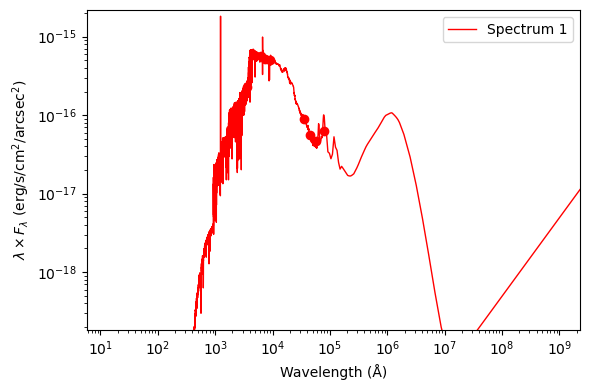

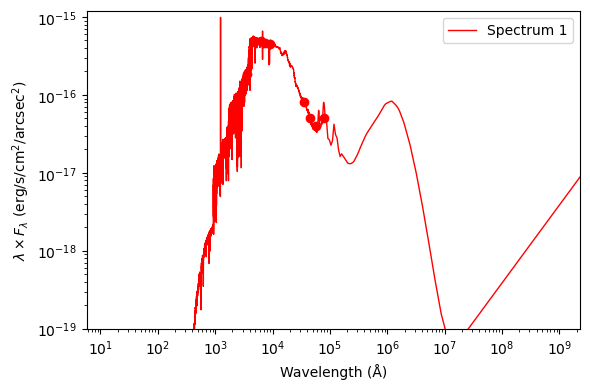

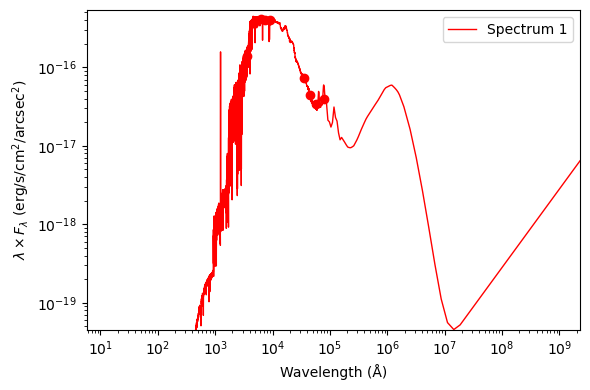

In [387]:


for age in np.linspace(100,1000,7):
    total_spec = fitter.synthetic_spectrum(
            metal=0.017,
            multi_component=True,
            age=age,
            tau_main=100,
            fesc=-0.004,
            av=0.2,
            av_ext= 0.094,
            alpha=2.35,
            m_star=9.2,
            ion_gas=-3.94,
            age_gas=3.997,
            redshift=0.02,
            dl=104,  # Luminosity distance in Mpc (assumed)
        )

       
    total_spec.plot(per_wavelength=True,bands=['galex_nuv','sdss_u','sdss_g','sdss_r','sdss_i','sdss_z',
                                                     'spitzer_irac_1','spitzer_irac_2','spitzer_irac_3','spitzer_irac_4'])

In [443]:
mock_spec = fitter.synthetic_spectrum(
            metal=0.017,
            multi_component=True,
            age=102,
            tau_main=100,
            fesc=-0.004,
            av=0.2,
            av_ext= 0.094,
            alpha=2.35,
            m_star=9.2,
            ion_gas=-3.94,
            age_gas=13,
            redshift=0.02,
            dl=104,  # Luminosity distance in Mpc (assumed)
        )



/tmp/ipykernel_92879/2254392165.py:95: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  norm_int, _ = quad(lambda l: trans_curve(l), lmin, lmax)


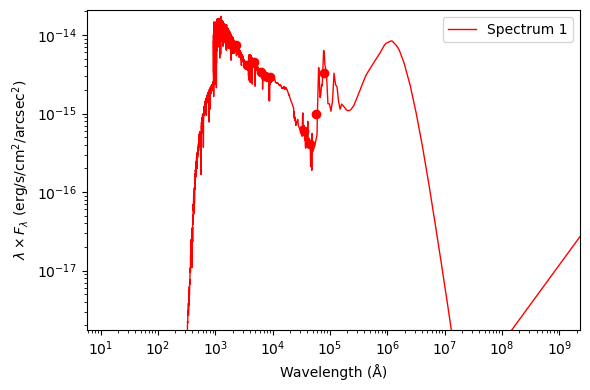

In [444]:
bands=['galex_nuv','sdss_u','sdss_g','sdss_r','sdss_i','sdss_z','spitzer_irac_1','spitzer_irac_2','spitzer_irac_3','spitzer_irac_4']
mock_spec.plot(per_wavelength=True,bands=bands)

phot_points = mock_spec.get_phot(bands=bands,units='mJy')

for b in bands: 
    value, error = phot_points.data[b]
    phot_points.data[b] = (value, 0.1 * value)



In [445]:
import pandas as pd
print(phot_points.pandas_df)

                   Value     Error   SNR
Band                                    
galex_nuv       0.000431  0.000043  10.0
sdss_u          0.000372  0.000037  10.0
sdss_g          0.000527  0.000053  10.0
sdss_r          0.000525  0.000052  10.0
sdss_i          0.000564  0.000056  10.0
sdss_z          0.000661  0.000066  10.0
spitzer_irac_1  0.000527  0.000053  10.0
spitzer_irac_2  0.000464  0.000046  10.0
spitzer_irac_3  0.001414  0.000141  10.0
spitzer_irac_4  0.006561  0.000656  10.0


In [446]:

results = fitter.run_fit(phot=phot_points, bands=bands, fix_pars={'ion_gas':-3.94,'age_gas':13,'fesc':-0.004,'av':0.2,'av_ext':0.094, #'trunctau':8.202,
                                   'alpha':2.35,'m_star':9.2,},)


Redshift not provided and not found in phot dictionary or spectrum header.
Redshift set to 0.
Using the following photometric filters: galex_nuv, sdss_u, sdss_g, sdss_r, sdss_i, sdss_z, spitzer_irac_1, spitzer_irac_2, spitzer_irac_3, spitzer_irac_4
🔎 Priors for this model:
⚓ Fixed parameters: ion_gas, age_gas, fesc, av, av_ext, alpha, m_star
Number of free parameters: 2
Initializing live points


/tmp/ipykernel_92879/2254392165.py:95: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  norm_int, _ = quad(lambda l: trans_curve(l), lmin, lmax)


Running dynesty


/tmp/ipykernel_92879/2254392165.py:95: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.: 80.919 +/-  0.142 | dlogz:  0.512 >  0.010] 
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  norm_int, _ = quad(lambda l: trans_curve(l), lmin, lmax)
/tmp/ipykernel_92879/2254392165.py:95: IntegrationWarning: The maximum number of subdivisions (50) has been achieved. 81.147 +/-  0.141 | dlogz:  0.241 >  0.010] 
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  proba

In [431]:
# Traceplot: evolution of parameters during sampling
#fig, axes = dyplot.traceplot(results)
#plt.show()

# Runplot: evidence and log-likelihood evolution
#fig, axes = dyplot.runplot(results)
#plt.show()


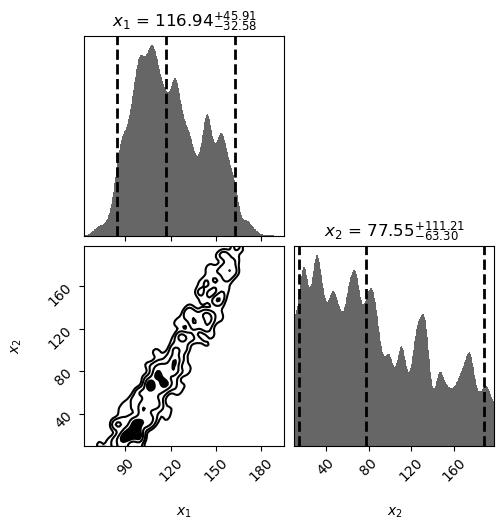

In [426]:
from dynesty import plotting as dyplot

fig, axes = dyplot.cornerplot(results, 
                              show_titles=True, 
                              title_fmt=".2f")
plt.show()

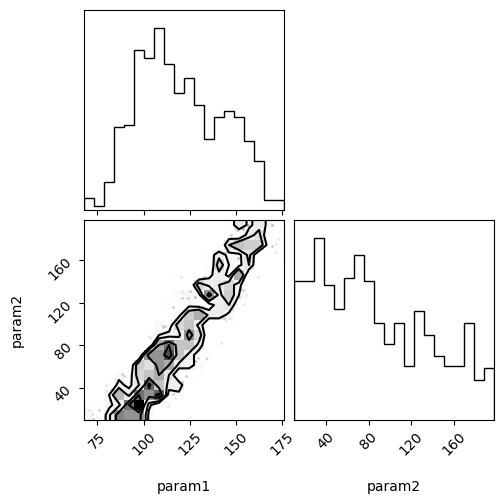

In [427]:
import numpy as np
import corner

# Get weighted samples
samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])

# Resample to equal weights
from dynesty.utils import resample_equal
equal_samples = resample_equal(samples, weights)

# Corner plot
fig = corner.corner(equal_samples, labels=["param1", "param2", "..."])
plt.show()



In [430]:
best_fit = equal_samples.mean(axis=0)
print("Best-fit parameters:", best_fit)

# Or MAP-like point
max_logl_idx = np.argmax(results.logl)
print("Maximum likelihood parameters:", results.samples[max_logl_idx])

Best-fit parameters: [119.81380835  85.92098099]
Maximum likelihood parameters: [104.29331071  47.54977691]
